In [1]:
import pickle
import matplotlib.pyplot as plt
import collections
import numpy as np
import itertools

%matplotlib inline

In [2]:
values = ['b_s_iou_10_list', 'b_w_iou_10_list', 'c_s_iou_10_list', 'c_w_iou_10_list', 'b_size_list', 'c_size_list']

In [3]:
def get_dict(exclu_filename, co_occur_filename, other_filename=None):
  with open(exclu_filename, 'rb') as handle:
      exclusive = pickle.load(handle)

  with open(co_occur_filename, 'rb') as handle:
    co_occur = pickle.load(handle)

  co_occur_results = collections.defaultdict(list)
  exclusive_results = collections.defaultdict(list)
  print('co_occur.keys(): ', co_occur.keys())
  for b in co_occur.keys():
    for key in values:
      exclusive_results[key].append(exclusive[b][key])
      co_occur_results[key].append(co_occur[b][key])

  print((exclusive_results['b_s_iou_10_list']))
  for key in values:
    exclusive_results[values] = list(itertools.chain.from_iterable(exclusive_results[values])
    co_occur_results[values] = list(itertools.chain.from_iterable(co_occur_results[values])
  
  return co_occur_results, exclusive_results

SyntaxError: invalid syntax (<ipython-input-3-7f8e3620c4bd>, line 19)

In [44]:
def get_meanvar(co_occuur, exclu, other=None):
  for key in values:
    print('Exclusive Mean, Std:')
    print(key + ': '+ np.nanmean(exclu[key])+', ' + np.nanstd(exclu[key]))

    print('Co-occur Mean, Std:')
    print(key + ': ', np.nanmean(co_occur[key])+', ' + np.nanstd(co_occur[key]))

  return

In [45]:
def get_histo(co_occur, exclu, other=None):
  plt.hist(np.array(exclu['b_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('L2 Distances')
  plt.xlabel('Exclusive (b)')
  plt.show()
  
  plt.hist(np.array(co_occur['b_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('L2 Distances')
  plt.xlabel('Co-occur (b)')
  plt.show()

  if other != None:
    plt.hist(np.array(other['b_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
    plt.ylabel('L2 Distances')
    plt.xlabel('Other (b)')
    plt.show()


  plt.hist(np.array(exclu['c_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('L2 Distances')
  plt.xlabel('Exclusive (c)')
  plt.show()

  plt.hist(np.array(co_occur['c_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('L2 Distances')
  plt.xlabel('Co-occur (c)')
  plt.show()
  if other != None:
    plt.hist(np.array(other['c_iou_list']).squeeze(), density=True, bins=30)  # density=False would make counts
    plt.ylabel('L2 Distances')
    plt.xlabel('Other (c)')
    plt.show()
    
  return

In [46]:
exclu_filename, co_occur_filename  = '/content/exclusive_results_iou.pkl', '/content/co_occur_results_iou.pkl'
co_occur, exclusive = get_dict(exclu_filename, co_occur_filename)
get_meanvar(co_occur, exclusive)
get_histo(co_occur, exclusive)

co_occur.keys():  dict_keys([41, 40, 26, 47, 2, 5, 58, 44, 68, 66, 30, 74, 32, 65, 31, 70, 78, 38, 36, 35])
20


TypeError: ignored

All_imgs.pkl
1.   List of length 20 (one for each biased category pair. 
2.   Each item in the list has 16k distances that represent 



In [ ]:
import os, pickle, copy, itertools
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [ ]:
root = './'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ContextualBiasStacking/decision_tree

/content/drive/MyDrive/ContextualBiasStacking/decision_tree


In [ ]:
def combine_models(dir_name: str, labels=False):
  result = None
  # validation: 0: featuresplit 1: standard 2: weighted
  # test: 0: standard 1: weighted
  for i, pkl_file in enumerate(sorted(os.listdir(dir_name))):
    print(pkl_file)
    features = pickle.load(open('{}/{}'.format(dir_name, pkl_file), 'rb'))
    if labels:
      result = features
    else: 
      features = np.expand_dims(features, axis=1) # get the M axis
      if i==0:
        result = features
      else:
        result = np.concatenate((result, features), axis=1)
    
  print('{} shape: {}'.format(dir_name, result.shape))
  return result

In [ ]:
# train_meta = combine_models('train_meta')
val_meta = combine_models(root+'val_meta')
test_meta = combine_models(root+'test_meta')

featuresplit_val_meta.pkl
standard_val_meta.pkl
weighted_val_meta.pkl
./val_meta shape: (16557, 3, 171)
standard_test_meta.pkl
weighted_test_meta.pkl
./test_meta shape: (40504, 2, 171)


In [ ]:
dir_name = root+'labels_list'
# labels_list_train = pickle.load(open('{}/{}'.format(dir_name, 'labels_list_80.pkl'), 'rb'))
labels_list_val = pickle.load(open('{}/{}'.format(dir_name, 'label_list_val.pkl'), 'rb'))
labels_list_test = pickle.load(open('{}/{}'.format(dir_name, 'label_list_test.pkl'), 'rb'))
# print('labels_list_train shape:', labels_list_train.shape)
print('labels_list_val shape:', labels_list_val.shape)
print('labels_list_test shape:', labels_list_test.shape)

labels_list_val shape: (16557, 171)
labels_list_test shape: (40504, 171)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class Dataset(Dataset):
    def __init__(self, meta_features, img_labels_list):
        # self.meta_features = meta_features > 0.5
        self.meta_features = meta_features 
        self.img_labels_list = img_labels_list

    def __len__(self):
        return self.img_labels_list.shape[0]

    def __getitem__(self, index):
        X = self.meta_features[index]
        y = self.img_labels_list[index]
        return X, y

In [ ]:
val_dset = Dataset(val_meta, labels_list_val)
val_bs = val_meta.shape[0]
val_loader = DataLoader(val_dset, batch_size=val_bs, shuffle=False, num_workers=1)

test_dset = Dataset(test_meta, labels_list_test)
test_bs = test_meta.shape[0]
test_loader = DataLoader(test_dset, batch_size=test_bs, shuffle=False, num_workers=1)

In [ ]:
biased_classes_mapped = pickle.load(open('../biased_classes_mapped.pkl', 'rb'))
humanlabels_to_onehot = pickle.load(open('../humanlabels_to_onehot.pkl', 'rb'))
unbiased_classes_mapped = pickle.load(open('../unbiased_classes_mapped.pkl', 'rb'))

onehot_to_humanlabels = dict((y,x) for x,y in humanlabels_to_onehot.items())
biased_classes_list = list(biased_classes_mapped.keys())

# Gather scores on the validation or the test set

In [ ]:
split = 'validation'

In [ ]:
if split == 'validation': loader = val_loader
elif split == 'test': loader = test_loader

In [ ]:
# Grab scores and labels (just need 1 loop because our batch size equals numsamples)
for _, (scores, labels) in enumerate(loader):
    scores = scores.numpy()
    labels = labels.numpy()

In [ ]:
# Assign the scores to the correct models
if split == 'validation':
    fs_scores = scores[:, 0, :]
    standard_scores = scores[:, 1, :]
    weighted_scores = scores[:, 2, :]
else:
    standard_scores = scores[:, 0, :]
    weighted_scores = scores[:, 1, :]

In [ ]:
nclasses = 171
nsamples = scores.shape[0]

In [ ]:
import pickle

all_imgs_filename = '/content/all_imgs.pkl'
with open(all_imgs_filename, 'rb') as handle:
    all_imgs = pickle.load(handle)

In [ ]:
all_imgs = np.squeeze(np.array(all_imgs))

In [ ]:
print(all_imgs.shape)

(20, 16557, 2)


In [ ]:
percent = []
for k in range(len(biased_classes_list)):
  b = biased_classes_list[k]
  c = biased_classes_mapped[b]
  #print(onehot_to_humanlabels[b], onehot_to_humanlabels[c])

  # Categorize the images into co-occur/exclusive/other                                                                                                  
  #cooccur = (labels[:,b]==1) & (labels[:,c]==1)
  exclusive = (labels[:,b]==1) & (labels[:,c]==0)
  #exclusive = (weighted_scores[:,b]>0.5) & (weighted_scores[:,c]<0.5)
  exclu_idx = set(np.squeeze(exclusive.nonzero()))
  #print('n_exclu: ', len(exclu_idx))
  #other = (~exclusive) & (~cooccur)
  portion = .10
  top_x = int(len(exclu_idx) * portion)
  if top_x==0:
    top_x=1
  print(top_x)

  #a = all_imgs[k][:,0]-all_imgs[k][:,1]
  # weighted_top_10 = weighted_scores[:, b]
  a = all_imgs[k][:,0]*weighted_scores[:,b]-all_imgs[k][:,1]*standard_scores[:,c]
  top_idx = set(np.argsort(a)[-top_x:])
  #print('exclu imgs: ', len(top_idx.intersection(exclu_idx)))
  #print((len(top_idx.intersection(exclu_idx))/top_x))
  percent.append((len(top_idx.intersection(exclu_idx))/top_x))
np.mean(percent)

In [ ]:
percent = []
a_20_e = []
a_20_c = []
for k in range(len(biased_classes_list)):
  b = biased_classes_list[k]
  c = biased_classes_mapped[b]
  
  exclusive = (labels[:,b]==1) & (labels[:,c]==0) # get gt
  cooccur = (labels[:,b]==1) & (labels[:,c]==1) # get gt
  exclu_idx = set(np.squeeze(exclusive.nonzero())) # create set of all idx

  # set a cutoff for top 10 and just see how many exclusive vs not (show number exclusive imgs in set, how many are identified, how many are missed)
  # tp, fn, total # exclu imgs
  
  portion = .25
  top_x = int(len(exclu_idx) * portion) 
  if top_x==0:
    top_x=1
  print(top_x)

  a_e = weighted_scores[exclusive, b] + (1-standard_scores[exclusive, c]) # look at distribution 
  a_c = weighted_scores[cooccur, b] + (1-standard_scores[cooccur, c]) # look at distribution 
  a_20_e.append(a_e)
  a_20_c.append(a_c)
  top_idx = set(np.argsort(a)[-top_x:])
  #print('exclu imgs: ', len(top_idx.intersection(exclu_idx)))
  #print((len(top_idx.intersection(exclu_idx))/top_x))
  percent.append((len(top_idx.intersection(exclu_idx))/top_x))
a_20_e = list(itertools.chain.from_iterable(a_20_e))
a_20_c = list(itertools.chain.from_iterable(a_20_c))
#np.mean(percent)

150
30
22
32
131
29
104
49
21
28
1
86
4
32
1
4
3
1
1
1


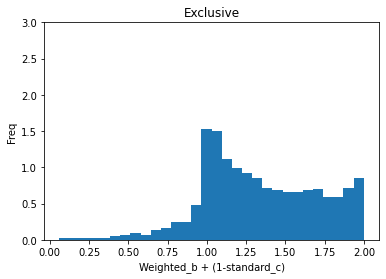

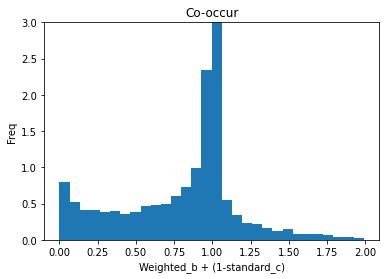

In [ ]:
plt.hist(a_20_e, density=True, bins=30)  # density=False would make counts
plt.ylabel('Freq')
plt.xlabel('Weighted_b + (1-standard_c)')
plt.title("Exclusive")
plt.ylim([0, 3])
plt.show()

plt.hist(a_20_c, density=True, bins=30)  # density=False would make counts
plt.ylabel('Freq')
plt.xlabel('Weighted_b + (1-standard_c)')
plt.title("Co-occur")
plt.ylim([0, 3])

plt.show()

In [ ]:
def get_dict(exclu_filename, co_occur_filename):
  with open(co_occur_filename, 'rb') as handle:
      co_occur = pickle.load(handle)

  with open(exclu_filename, 'rb') as handle:
      exclusive = pickle.load(handle)

  co_occur_results = collections.defaultdict(list)
  exclusive_results = collections.defaultdict(list)
  for b in co_occur.keys():
    exclusive_results['b_mse_list'].append(exclusive[b]['b_mse_list'])
    co_occur_results['b_mse_list'].append(co_occur[b]['b_mse_list'])
    exclusive_results['c_mse_list'].append(exclusive[b]['c_mse_list'])
    co_occur_results['c_mse_list'].append(co_occur[b]['c_mse_list'])

  exclusive_results['b_mse_list'] = list(itertools.chain.from_iterable(exclusive_results['b_mse_list']))
  co_occur_results['b_mse_list'] = list(itertools.chain.from_iterable(co_occur_results['b_mse_list']))
  exclusive_results['c_mse_list'] = list(itertools.chain.from_iterable(exclusive_results['c_mse_list']))
  co_occur_results['c_mse_list'] = list(itertools.chain.from_iterable(co_occur_results['c_mse_list']))
  
  
  return co_occur_results, exclusive_results

In [ ]:
def get_meanvar(co_occuur, exclu):
  print('Mean:')
  print('exclusive b: ', np.mean(exclu['b_mse_list']))
  print('co_occur b: ', np.mean(co_occur['b_mse_list']))
  print('exclusive c: ', np.mean(exclu['c_mse_list']))
  print('co_occur c: ', np.mean(co_occur['c_mse_list']))

  print('Variance:')
  print('exclusive b: ', np.var(exclu['b_mse_list']))
  print('co_occur b: ', np.var(co_occur['b_mse_list']))
  print('exclusive c: ', np.var(exclu['c_mse_list']))
  print('co_occur c: ', np.var(co_occur['c_mse_list']))
  return

In [ ]:
def get_histo(co_occur, exclu):
  plt.hist(np.array(exclu['b_mse_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('MSE')
  plt.xlabel('Exclusive (b)')
  plt.show()
  
  plt.hist(np.array(co_occur['b_mse_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('MSE')
  plt.xlabel('Co-occur (b)')
  plt.show()

  plt.hist(np.array(exclu['c_mse_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('MSE')
  plt.xlabel('Exclusive (c)')
  plt.show()

  plt.hist(np.array(co_occur['c_mse_list']).squeeze(), density=True, bins=30)  # density=False would make counts
  plt.ylabel('MSE')
  plt.xlabel('Co-occur (c)')
  plt.show()

  return

Mean:
exclusive b:  54.93600652152169
co_occur b:  54.40435427682993
exclusive c:  50.85107070792149
co_occur c:  52.214649256208034
Variance:
exclusive b:  86.98378705220858
co_occur b:  91.6574352049862
exclusive c:  93.20196574178063
co_occur c:  85.65311857676247


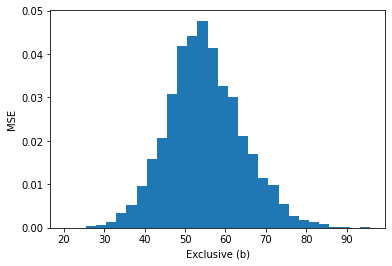

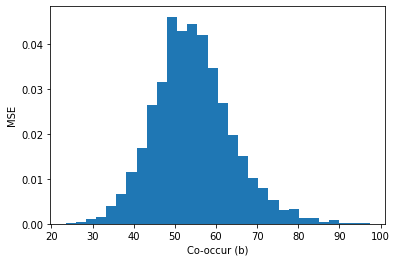

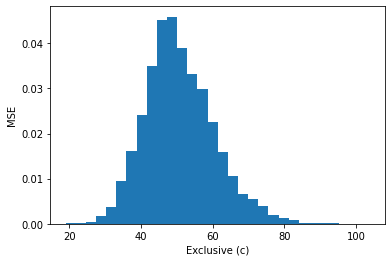

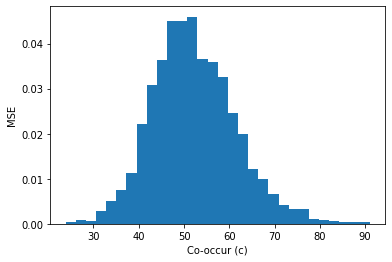

In [ ]:
exclu_filename, co_occur_filename = '/content/co_occur_results_normalized_zero_0.pkl', '/content/exclusive_results_normalized_zero_0.pkl'
co_occur, exclusive = get_dict(exclu_filename, co_occur_filename)
get_meanvar(co_occur, exclusive)
get_histo(co_occur, exclusive)
